# **Quantile Optimal Treatment Regime**
---

###    **Motivation:**  
Aside from evaluating the performance of a target policy or finding the optimal treatment regimes with respect to the **mean outcome**, it is natural to extend the mean outcome to exploring the whole reward distribution. The easiest way to conduct policy evaluation and optimization is to estimate the quantiles with respect to some quantile levels in $[0,1]$. There are some cases when it is not satisfactory to only evaluate the mean outcome:



1.   **The problem of our interest may not be limited to the mean outcome**: For example, when evaluating the performance of a certain policy in prolonging customers watching time on a video platform, one may be interested in how well the policy is in stimulating the customers at the lower 25% tail, so as to improve the overall prevalence of this platform and attract more potential customers.

2.   **Heavy tails**: In the case when the reward distribution is naturally heavy-tailed, the performance of directly estimating the mean outcome (or doing optimization) may be very unstable. In this case, we may want to know the whole picture of the outcome distribution in order to do further statistical inferences.
3.   **Skewed distribution**: For example, in the cases when we would like to evaluate the survival time of patients, it may be desirable to consider the treatment regime that maximizes the median of the distribution of the potential outcome.


Note: the recent work on discrete Q-learning in Moodie et al. (2014)[2] can be
applied to first estimate the probabilities and then invert them to estimate quantiles, but simply taking the inverse to the cummulative density function may cause a lot of potential problems to the qunatile estimation and optimization. 


---


### **Main Idea:** 
In recent years, there are more work focusing on quantile estimating the optimal treatment regime in order to maximize the qunatile at level $\tau$ given a class of feasible treatment regimes $\mathbb{D}=\{I(X^T\beta>0:\beta\in \mathbb{B})\}$. That is, the objective function is to maximize
   $$\arg\max_{d\in \mathbb{D}}Q_{\tau}(Y^*(d)),$$
where $Q_{\tau}$ denotes the quantile value at level $\tau$. \\


There are multiple ways to estimate the quantile value at a given level $\tau$: direct method, inverse probability estimator, and doubly robust estimator. Among all of the three methods, doubly robust estimator (or AIPW estimator) is the one that combines the advantages of both direct method and IPW estimator, which allows some part of the model to be misspecified while pretaining the consistency of the estimation. For an AIPW estimator, the quantile can be estimated by
$$
\hat{Q}_{\tau}(\beta)=\frac{1}{n}\sum_{i=1}^n \left[\frac{C_i(\beta)}{\hat{\pi}(X_i,\beta)}\rho_{\tau}(Y_i-a)+\left(1-\frac{C_i(\beta)}{\hat{\pi}(X_i,\beta)}\right)\rho_{\tau}(\hat{Y}_i^{**}-a)\right],
$$
where $\hat{Y}_i^{**}$ is the pseudo outcome generated from the fitted model when following some policy $d(X_i,\beta)$.
Thus, the optimal policy to maximize a specific quantile of the outcome distribution can be obtained by
$$
\arg\max_{\beta\in\mathbb{B}}\hat{Q}_{\tau}(\beta)
$$


---


### **Algorithm:** 
The main steps of this algorithm can be summarized as follows:


1.   Fit the following models by any appropriate method you want: \\
(a). Propensity score $\pi(X_i,\beta)$. Usually the simplest way is to use Logistic regression.\\
(b). Outcome regression model when treatment $A=1$. We estimate the conditional quantile $Q_{\tau}(Y^*(1)|X)=g(X,\beta_1(\tau))$, for $\tau$ in a fine grid of $(0,1)$. This yields $\hat{\beta}_1(\tau)$, $\tau\in(0,1)$.\\
(c). Outcome regression model when treatment $A=0$. We estimate the conditional quantile $Q_{\tau}(Y^*(0)|X)=g(X,\beta_0(\tau))$, for $\tau$ in a fine grid of $(0,1)$. This yields $\hat{\beta}_0(\tau)$, $\tau\in(0,1)$.
2.  Generate two independent random samples from the uniform distribution on the interval $(0,1)$: $\{u_{11},\dots,u_{1n}\}$ and $\{u_{01},\dots,u_{0n}\}$.
3.  Calculate $\hat{Y}^{**}_i=g(X_i,\hat{\beta}_1(u_{1i}))d(X_i,\beta)+g(X_i,\hat{\beta}_0(u_{0i}))(1-d(X_i,\beta))$, $i=1,\dots,n$.
4.  Using proper methods to find the optimal $\beta$ for $\hat{Q}_{\tau}(\beta)$. Nelder-mead method was implemented in the following algorithm.



---



### **Demo:** 
*   Next, we will use both the simulation data and a real dataset to illustrate the performance of Quantile Optimal Treatment Regime in Wang et al. (2018) [1].
---

## **Single stage setting**

### **Demo on Simulation data**

In [ ]:
# define some functions to generate the original data

# definition of behavior policy (or original treatment function)
def b(x1,x2):
    if np.shape(x1) == ():
      x1 = np.array([x1])
    if np.shape(x2) == ():
      x2 = np.array([x2])
    n = len(x1)
    epsilon = 0.25 * np.random.normal(size=n)
    return ((x1+x2 + epsilon > 0) + 0)

# definition of target policy (or the treatment of our interest)
def pi(x1,x2):
    if np.shape(x1) == ():
      x1 = np.array([x1])
    if np.shape(x2) == ():
      x2 = np.array([x2])
    n = len(x1)
    return ((x1+x2 > 0) + 0)

# definition of reward function r(x,a), where x denotes states and a denotes actions(treatments)
def r(x1, x2, a):
    if np.shape(x1) == ():
      x1 = np.array([x1])
    if np.shape(x2) == ():
      x2 = np.array([x2])
    if np.shape(a) == ():
      a = np.array([a])
    n = len(x1)
    epsilon = 0.25 * np.random.normal(size=n)
    return (np.ones(n) - x1 + 2*a*x1 +2*x2 +0.5*a*x2) * (np.ones(n) + epsilon)

In [ ]:
n0 = (10**3)  # the number of samples used to estimate the true reward distribution by MC

np.random.seed(seed=223)
import pandas as pd
import numpy as np
tau=0.5
X_1=np.random.normal(loc=-0.5,size=n0)
X_2=np.random.normal(loc=0.6,size=n0)
A=b(X_1,X_2)
Y=r(X_1, X_2, A) 
data={'X_1':X_1,'X_2':X_2,'A':A,'Y':Y}
data=pd.DataFrame(data)
(data)

,X_1,X_2,A,Y
0,0.034775,2.453145,1,6.025941
1,0.084880,-1.234459,0,-1.121537
2,-0.144626,2.040543,1,4.806875
3,0.148426,-0.021139,1,1.637488
4,-0.120852,1.377594,1,3.363393
...,...,...,...,...
995,-2.022440,1.887551,0,6.641093
996,0.411179,-1.655833,0,-2.525509
997,0.155706,-0.992197,0,-1.381373
998,-1.510241,0.828438,0,3.342528


In [ ]:
# initialize the learner
Quantile_OTR=QuantileOTR()

# when a=1, Y ~ 1+x1+2.5*x2
# when a=0, Y ~ 1-x1+2*x2
moCondQuant_0 = ['X_1', 'X_2']
moCondQuant_1 = ['X_1', 'X_2']

coefficient, coef_original_scale, Q_est=Quantile_OTR.DR_Qopt(data=data, tau=0.5, moCondQuant_0=moCondQuant_0, moCondQuant_1=moCondQuant_1,moPropen = "NotBinaryRandom")

Optimization terminated successfully.
         Current function value: 0.129150
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18


In [ ]:
# the coefficient that maximize the quantile
coef_original_scale

array([0.1668, 0.1462, 2.0194])

In [ ]:
# the estimated quantile that corresponds to the optimized coefficient
Q_est

1.8429162304108773

### **Demo on Real dataset**

#### Data pre-processing

In [ ]:
!pip install scikit-uplift

In [ ]:
from sklift.datasets import fetch_hillstrom
# continuous Y
data, target, treatment = fetch_hillstrom(target_col='spend', return_X_y_t=True)

  0%|          | 0.00/443k [00:00<?, ?iB/s]

In [ ]:
data

,recency,history_segment,history,mens,womens,zip_code,newbie,channel
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web
...,...,...,...,...,...,...,...,...
63995,10,2) $100 - $200,105.54,1,0,Urban,0,Web
63996,5,1) $0 - $100,38.91,0,1,Urban,1,Phone
63997,6,1) $0 - $100,29.99,1,0,Urban,1,Phone
63998,1,5) $500 - $750,552.94,1,0,Surburban,1,Multichannel


In [ ]:
np.sum(target!=0) # only 578 samples among a total of 64000 have non-zero spend

578

In [ ]:
treatment.replace(['Womens E-Mail', 'No E-Mail', 'Mens E-Mail'],[1, 0, 1], inplace=True) 
treatment[target>0]

217      1
267      1
332      0
451      1
459      1
        ..
63466    0
63552    0
63743    1
63876    1
63883    1
Name: segment, Length: 578, dtype: int64

In [ ]:
# use pd.concat to join the new columns with your original dataframe
data = pd.concat([data,pd.get_dummies(data['zip_code'], prefix='zip_code')],axis=1)
data = pd.concat([data,pd.get_dummies(data['channel'], prefix='channel')],axis=1)
# now drop the original 'country' column (you don't need it anymore)
data.drop(['zip_code'],axis=1, inplace=True)
data.drop(['channel'],axis=1, inplace=True)
data.drop(['history_segment'],axis=1, inplace=True)
data.drop(['zip_code_Rural'],axis=1, inplace=True) # Rural as the reference group
data.drop(['channel_Multichannel'],axis=1, inplace=True) # Multichannel as the reference group 

'''
Y = np.array(target)
X = np.hstack([np.ones((len(data),1)),np.array(data)])# add an intercept column
# convert the categorical variable into integers with treatment 0 = No emails
treatment.replace(['Womens E-Mail', 'No E-Mail', 'Mens E-Mail'],[1, 0, 2], inplace=True) 
treatment = np.array(treatment)
#get the subset which has Y>0 == n=578
X = X[Y>0]
A = {}
A[0] = treatment[Y>0]
Y = Y[Y>0]
'''

"\nY = np.array(target)\nX = np.hstack([np.ones((len(data),1)),np.array(data)])# add an intercept column\n# convert the categorical variable into integers with treatment 0 = No emails\ntreatment.replace(['Womens E-Mail', 'No E-Mail', 'Mens E-Mail'],[1, 0, 2], inplace=True) \ntreatment = np.array(treatment)\n#get the subset which has Y>0 == n=578\nX = X[Y>0]\nA = {}\nA[0] = treatment[Y>0]\nY = Y[Y>0]\n"

In [ ]:
data

,recency,history,mens,womens,newbie,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,1,0
1,6,329.08,1,1,1,0,0,0,1
2,7,180.65,0,1,1,1,0,0,1
3,9,675.83,1,0,1,0,0,0,1
4,2,45.34,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,0,0,1,0,1
63996,5,38.91,0,1,1,0,1,1,0
63997,6,29.99,1,0,1,0,1,1,0
63998,1,552.94,1,0,1,1,0,0,0


In [ ]:
Data=data[target>0].copy()
#X['Intercept']=np.ones((len(data),1))
Data['A']=treatment[target>0]
Data['Y']=target[target>0]

# The final data we will use
Data

,recency,history,mens,womens,newbie,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,A,Y
217,10,88.37,0,1,0,0,1,1,0,1,29.99
267,4,297.80,1,1,0,0,1,1,0,1,264.66
332,10,29.99,0,1,0,1,0,0,1,0,149.28
451,6,265.61,0,1,1,1,0,0,0,1,42.66
459,1,101.99,0,1,0,1,0,0,1,1,29.99
...,...,...,...,...,...,...,...,...,...,...,...
63466,9,536.80,1,1,1,0,0,0,1,0,117.84
63552,2,980.39,1,0,1,0,1,1,0,0,90.57
63743,5,210.12,0,1,0,1,0,1,0,1,113.44
63876,2,215.61,1,0,0,0,0,0,1,1,99.49


#### Quantile Optimal Treatment Regime

In [ ]:
# initialize the learner
Quantile_OTR=QuantileOTR()

moCondQuant_0 = ['recency',	'history',	'mens',	'womens',	'newbie',	'zip_code_Surburban',	'zip_code_Urban',	'channel_Phone',	'channel_Web']
moCondQuant_1 = ['recency',	'history',	'mens',	'womens',	'newbie',	'zip_code_Surburban',	'zip_code_Urban',	'channel_Phone',	'channel_Web']

coefficient, coef_original_scale, Q_est=Quantile_OTR.DR_Qopt(data=Data, tau=0.5, moCondQuant_0=moCondQuant_0, moCondQuant_1=moCondQuant_1,moPropen = "NotBinaryRandom")

         Current function value: 0.502953
         Iterations: 35
         Function evaluations: 45
         Gradient evaluations: 40


In [ ]:
# the coefficient that maximize the quantile
coef_original_scale

array([9.0909e-02, 4.7368e-04, 1.0000e+00, 1.0000e+00, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 8.9489e-01])

In [ ]:
# the estimated quantile that corresponds to the optimized coefficient
Q_est

81.64

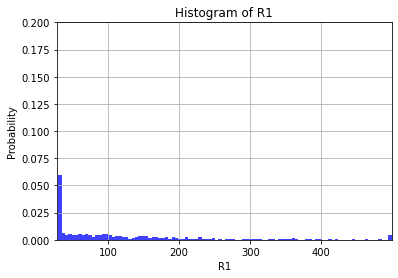

In [ ]:
n, bins, patches = plt.hist(Data['Y'], bins=100,density=True, facecolor = "blue",alpha=0.75)


plt.xlabel('R1')
plt.ylabel('Probability')
plt.title('Histogram of Target')
plt.xlim(np.min(Data['Y']-2), np.max(Data['Y']))
plt.ylim(0, 0.2)
plt.grid(True)
plt.show()

In [ ]:
np.percentile(Data['Y'], 0.5*100)

80.795

## **Multiple Stage Setting**

##**Reference**


*   [1] Lan Wang, Yu Zhou, Rui Song and Ben Sherwood. "Quantile-Optimal Treatment Regimes." Journal of the American Statistical Association 2018; 113(523): 1243–1254.
*   [2] Moodie, E., Dean, N., and Sun, Y. (2014). Q-learning: Flexible learning about useful utilities. Statistics in Biosciences, 6:223243.





In [ ]:
!pip install -U jupyter-book


     |████████████████████████████████| 43 kB 1.3 MB/s 
     |████████████████████████████████| 87 kB 3.9 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 292 kB 44.0 MB/s 
     |████████████████████████████████| 41 kB 37 kB/s 
     |████████████████████████████████| 3.1 MB 42.9 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 83 kB 1.9 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 46 kB 3.5 MB/s 
     |████████████████████████████████| 5.3 MB 17.9 MB/s 
     |████████████████████████████████| 41 kB 34 kB/s 
     |████████████████████████████████| 130 kB 46.2 MB/s 
     |████████████████████████████████| 121 kB 45.7 MB/s 
     |████████████████████████████████| 100 kB 9.1 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 90 kB 8.5 MB/s 
     |████████████████████████████████|

Usage: jupyter-book build [OPTIONS] PATH_SOURCE
Try 'jupyter-book build -h' for help.

Error: Invalid value for 'PATH_SOURCE': Path 'Causal-Decision-Making' does not exist.


In [ ]:
!jupyter-book build Causal-Decision-Making

Usage: jupyter-book build [OPTIONS] PATH_SOURCE
Try 'jupyter-book build -h' for help.

Error: Invalid value for 'PATH_SOURCE': Path 'Causal-Decision-Making' does not exist.
